[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1ytO1pdnDE-1C-cwipnlRd2J9OGuET8a_?usp=sharing)

## Install dependencies

In [1]:
!pip install likelihood --quiet
!pip install gdown --quiet
!pip install xgbfir --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 5.2 MB/s eta 0:00:00


# Gradient Boosting algorithms

In [2]:
import pandas as pd
import xgboost as xgb
import xgbfir

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from likelihood.tools import *
import gdown

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Dataset Description

**Objective:** The dataset is designed for predicting the `effectiveness` of various sales managers using the XGBoost algorithm.

## Columns

- **date**: Date of the observation, indicating when the data was collected.

- **id_manager**: Unique identifier for each sales manager.

- **id_business_line**: Unique identifier for each business line.

- **target_sales_manager**: A target metric related to the sales manager's goals.

- **departamento**: Department where the sales manager operates.

- **studies**: Educational qualifications of the sales manager, potentially impacting their effectiveness.

- **generation**: The generational cohort the sales manager belongs to (e.g., Millennials, Gen X), which may influence their work style and effectiveness.

- **location**: Geographical location where the sales manager operates, potentially affecting performance due to regional factors.

- **gender**: Gender of the sales manager, which could be a demographic variable for analyzing effectiveness.

- **age**: Age of the sales manager, which might correlate with experience and effectiveness.

- **direct_boss**: The direct superior of the sales manager, which might influence the sales manager's effectiveness.

- **position**: Job position of the sales manager.

- **rh_location**: Location of the human resources department.

- **civil_status**: Civil status (e.g., single, married) of the sales manager, which could impact their personal and professional life balance.

- **cell_phone**: Contact number of the sales manager, which may be used for direct communication but may not be directly relevant for prediction.

- **total_sales**: Total sales achieved by the sales manager.

- **clients**: Number of clients handled by the sales manager, potentially influencing their sales performance.

- **potential_clients**: Number of potential clients identified by the sales manager, indicating future sales opportunities.

- **number_employees**: Number of employees under the sales manager’s supervision, which could affect their workload and performance.

- **program**: Program or initiative the sales manager is involved in, which might be linked to their effectiveness.

- **clients_ratio**: Ratio of clients to some other metric (e.g., `total_clients` / `potential_clients` $> 0.25$), providing insight into client management efficiency.

- **sales_ratio**: Ratio of sales to another metric (e.g., `total_sales` / `target_sales_manager` $> 0.65$), which may reflect the sales manager's performance relative to targets.

- **effectiveness**: Target variable representing the effectiveness of the sales manager, which the model aims to predict.

## Summary

The dataset contains a mix of demographic, operational, and performance-related features about sales managers. The goal is to use these attributes to build a predictive model that accurately estimates the effectiveness of sales managers.


In [3]:
url = "https://drive.google.com/file/d/1tfn0x45VIdYtO-VOTQh5cmSNnsXaNGVX/view?usp=sharing"
output_path = "./data.parquet"
gdown.download(url, output_path, quiet=False, fuzzy=True)

df = pd.read_parquet("./data.parquet")
df.head()

Downloading...
From: https://drive.google.com/uc?id=1tfn0x45VIdYtO-VOTQh5cmSNnsXaNGVX
To: /content/data.parquet
100%|██████████| 286k/286k [00:00<00:00, 39.9MB/s]


,date,id_manager,id_business_line,target_sales_manager,department,studies,generation,location,gender,age,...,civil_status,cell_phone,total_sales,clients,potential_clients,number_employees,program,clients_ratio,sales_ratio,effectiveness
2,2022-01-01,58,2.0,2022875.0,322.0,University Graduate,Generation X,New York New York,F,50.0,...,Single,Yes,3.732175e+06,75,234,60,False,1,1,1
3,2022-01-01,58,2.0,2022875.0,322.0,University Graduate,Generation X,New York New York,F,50.0,...,Single,Yes,4.527792e+04,0,6,4,True,0,0,0
4,2022-01-01,58,4.0,2935888.0,322.0,University Graduate,Generation X,New York New York,F,50.0,...,Single,Yes,3.732175e+06,75,234,60,False,1,1,1
5,2022-01-01,58,4.0,2935888.0,322.0,University Graduate,Generation X,New York New York,F,50.0,...,Single,Yes,4.527792e+04,0,6,4,True,0,0,0
6,2022-01-01,102,2.0,514899.0,322.0,Tech-School Graduate,Generation X,Los Angeles California,F,44.0,...,Married,Yes,3.553355e+06,96,831,55,False,0,1,0


## EDA - Exploratory Data Analysis

In [4]:
palette = [
    "#FC814A",
    "#816581",
    "#96939B",
    "#BFBFBF",
    "#E8E8E8",
    "#5F3B3B",
    "#F0EAD6",
    "#72A7D0",
    "#D3A76C",
    "#BB4430",
    "#4D4D4D",
    "#A6C5E2",
    "#B9C9A9",
    "#E3C8B3",
    "#7851A9",
    "#C8AD7F",
]

drop_columns = ["date", "id_manager", "location", "rh_location", "direct_boss"]
df_copy = df.drop(columns=drop_columns)
num_charts = len([col for col in df_copy.columns if df_copy[col].dtype == "object"])

for col in df_copy.columns:
    if df_copy[col].dtype == "object":
        # Pie chart
        pie_data = df_copy[col].value_counts()
        pie_fig = go.Figure(
            data=[
                go.Pie(
                    labels=pie_data.index,
                    values=pie_data.values,
                    hole=0.3,
                    marker=dict(colors=palette),
                )
            ]
        )
        pie_fig.update_layout(
            title_text=f"Frequency per {col}",
            annotations=[dict(text=f"{col}", x=0.5, y=0.5, font_size=20, showarrow=False)],
        )
        pie_fig.show()

        # Stacked bar chart with percentages
        grouped = df_copy.groupby(["effectiveness", col]).size().unstack()
        grouped_pct = grouped.apply(lambda x: x / x.sum() * 100, axis=1)

        bar_fig = go.Figure()

        colors = palette[: len(grouped.columns)]

        for i, c in enumerate(grouped.columns):
            bar_fig.add_trace(
                go.Bar(
                    x=grouped.index,
                    y=grouped[c],
                    name=c,
                    text=grouped_pct[c].apply(lambda x: f"{x:.1f}%"),
                    textposition="inside",
                    marker=dict(color=colors[i]),
                )
            )

        bar_fig.update_layout(
            title=f"Event Distribution by {col}",
            xaxis_title="Effectiveness",
            yaxis_title="Count",
            barmode="stack",
            xaxis=dict(type="category"),
        )
        bar_fig.show()

## XGBoost

In [5]:
handler = DataFrameEncoder(df)
df_encoded = handler.encode("./", dictionary_name="eff_dict")

y = df_encoded["effectiveness"]
X = df_encoded.drop(
    columns=[
        "date",
        "id_manager",
        "clients_ratio",
        "sales_ratio",
        "clients",
        "potential_clients",
        "total_sales",
        "target_sales_manager",
        "effectiveness",
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

xgb_class = xgb.XGBClassifier(random_state=42)
xgb_class.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [6]:
xgb_class.score(X_test, y_test)

0.8285512699905927

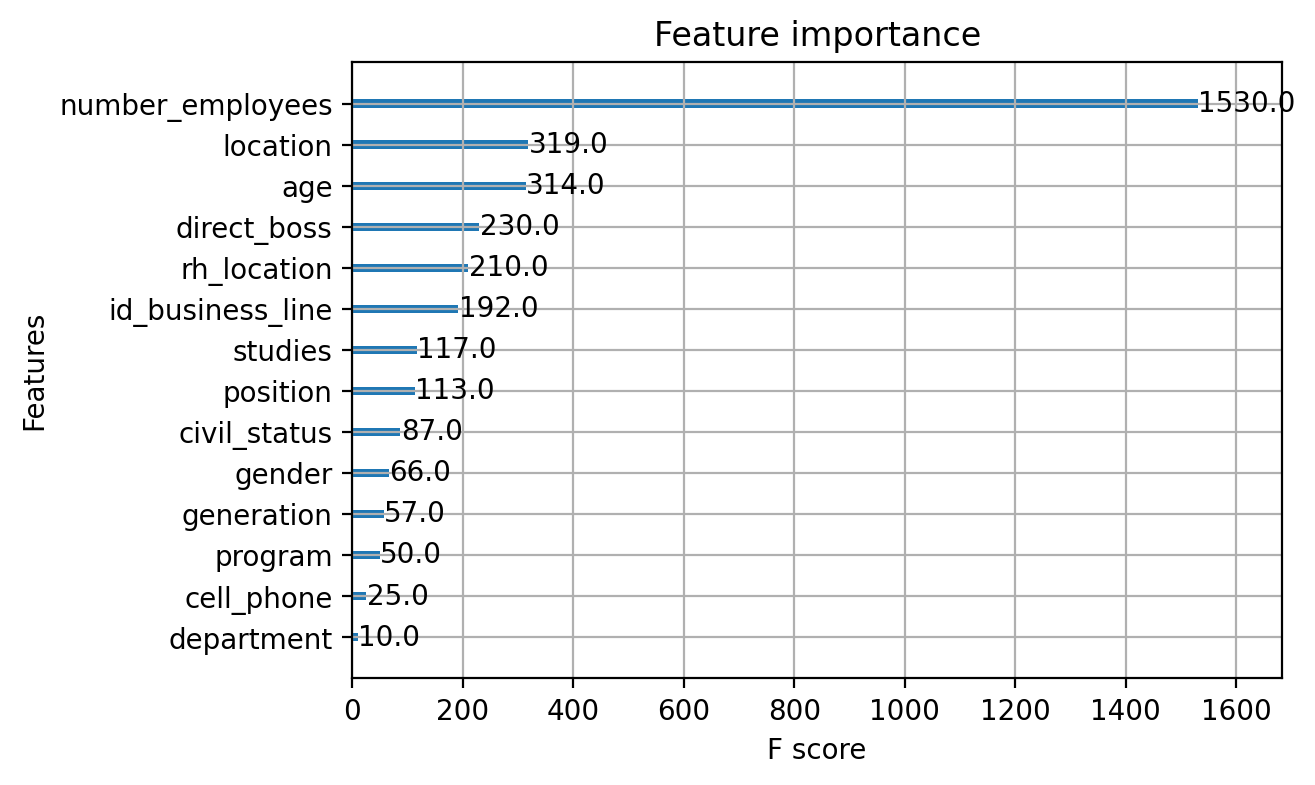

In [7]:
fig, ax = plt.subplots(figsize=(6, 4))
xgb.plot_importance(xgb_class, ax=ax)
fig.savefig("./mlpr_1000.png", dpi=300)
plt.show()

In [8]:
xgbfir.saveXgbFI(xgb_class, feature_names=X.columns, OutputXlsxFile="./mlpr_eff.xlsx")